**Завдання:**
    
Використовуючи наведений в лекції датасет і код, створіть на основі двошарової нейромережі тришарову. Оцініть її похибку та точність визначення класів. 

Після цього використайте для оцінки похибки **Mean Squared Error**, в якості оптимізатора - **Adam**. Порівняйте, чи змінилась похибка та точність.

In [20]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchviz

In [21]:
nX, nH1, nH2, nY = 2, 5, 5, 1

In [22]:
model = nn.Sequential(
            nn.Linear(nX, nH1),
            nn.Sigmoid(),
            nn.Linear(nH1, nH2),
            nn.Sigmoid(),
            nn.Linear(nH2, nY),
            nn.Sigmoid())

In [23]:
class ThreeLayersNet(nn.Module):
    def __init__(self, nX, nH1, nH2, nY):        
        super(ThreeLayersNet, self).__init__()   # конструктор
         
        self.fc1 = nn.Linear(nX, nH1)            # створення параметрів моделі у повнозв'язкових шарах
        self.fc2 = nn.Linear(nH1, nH2)
        self.fc3 = nn.Linear(nH2, nY)             
          
    def forward(self, x):                        # задаємо прямий прохід
        x = self.fc1(x)                          # вихід першого шару
        x = nn.Sigmoid()(x)                      # сигмоїдна активація
        x = self.fc2(x)                          # вихід другого шару
        x = nn.Sigmoid()(x)                      # сигмоїдна активація
        x = self.fc3(x)                          # вихід третього шару
        x = nn.Sigmoid()(x)                      # сигмоїдна активація       
        return x
          
model = ThreeLayersNet(2, 5, 5, 1)               # створення екземпляру класу

In [24]:
X = torch.rand (1200,2)                       
Y = (torch.sum((X - 0.5)**2, axis=1) < 0.1).float().view(-1,1)

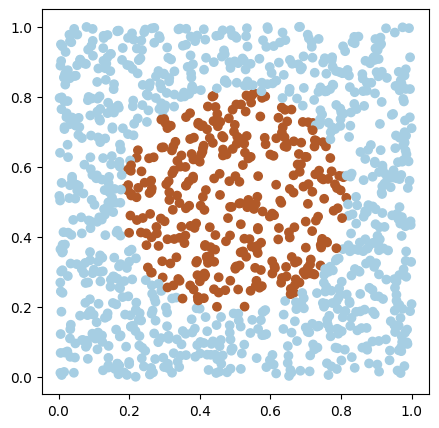

In [25]:
plt.figure (figsize=(5, 5))
plt.scatter(X.numpy()[:,0], X.numpy()[:,1], c=Y.numpy()[:,0],cmap=plt.cm.Paired)        
plt.show()

In [54]:
model = ThreeLayersNet(2, 5, 5, 1)
loss      = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.8)

In [55]:
def fit(model, X,Y, batch_size=100, train=True):    
    model.train(train)                                 
    sumL, sumA, numB = 0, 0, int( len(X)/batch_size ) 

    for i in range(0, numB*batch_size, batch_size):          
        xb = X[i: i+batch_size]                          # поточний батч
        yb = Y[i: i+batch_size]                          # тензори поточного батчу

        y = model(xb)                                    # пряме розповсюдження
        L = loss(y, yb)                                  # похибка

        if train:                                        # в режимі навчання
            optimizer.zero_grad()                        # обнуляємо градієнти,        
            L.backward()                                 # обчислюємо градієнти,            
            optimizer.step()                             # підганяємо параметри

        sumL += L.item()                                 # сумарна похибка
        sumA += (y.round() == yb).float().mean()         # точність визначення окремого класу

    return sumL/numB,  sumA/numB   

In [56]:
print( "before:      loss: %.4f accuracy: %.4f" %  fit(model, X,Y) )  # режим оцінки моделі
 
epochs = 1000                                                         # число епох
for epoch in range(epochs):                                           # епоха: прохід
    L,A = fit(model, X, Y)                                            # по всьому датасету
     
    if epoch % 100 == 0 or epoch == epochs-1:                 
        print(f'epoch: {epoch:5d} loss: {L:.4f} accuracy: {A:.4f}') 

before:      loss: 0.6019 accuracy: 0.7225
epoch:     0 loss: 0.6007 accuracy: 0.7225
epoch:   100 loss: 0.5941 accuracy: 0.7225
epoch:   200 loss: 0.5876 accuracy: 0.7225
epoch:   300 loss: 0.4392 accuracy: 0.7500
epoch:   400 loss: 0.4078 accuracy: 0.7592
epoch:   500 loss: 0.4044 accuracy: 0.7550
epoch:   600 loss: 0.1095 accuracy: 0.9567
epoch:   700 loss: 0.0528 accuracy: 0.9783
epoch:   800 loss: 0.0327 accuracy: 0.9900
epoch:   900 loss: 0.0249 accuracy: 0.9908
epoch:   999 loss: 0.0214 accuracy: 0.9908


In [57]:
print(model)

ThreeLayersNet(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
)


In [58]:
dict(model.named_parameters())

{'fc1.weight': Parameter containing:
 tensor([[ 16.0335,  -3.6161],
         [ -5.1315,  -6.2431],
         [ 12.3757,  -5.4231],
         [  1.4706,  13.4533],
         [ -3.6947, -13.0619]], requires_grad=True),
 'fc1.bias': Parameter containing:
 tensor([ -2.3392,   8.8477,  -6.4942, -10.4859,   4.4900], requires_grad=True),
 'fc2.weight': Parameter containing:
 tensor([[ -8.3254,  -5.2510,  13.2113,  11.7202,   0.6855],
         [ -8.4330,   1.4879,   7.8435,  -0.5536,  12.5745],
         [-11.0926,   1.6382,  -1.9554,  -0.8530,   3.6062],
         [ -0.8348,  -0.4822,  -0.6237,   0.0742,  -0.8943],
         [ -2.2673,  -0.3791,  -1.3011,  -0.0723,  -0.3687]],
        requires_grad=True),
 'fc2.bias': Parameter containing:
 tensor([ 2.5002, -1.0682,  0.2296, -1.0427, -1.3731], requires_grad=True),
 'fc3.weight': Parameter containing:
 tensor([[-19.0791, -17.3848,  -8.7716,   0.6428,  -0.3547]],
        requires_grad=True),
 'fc3.bias': Parameter containing:
 tensor([9.4365], requir

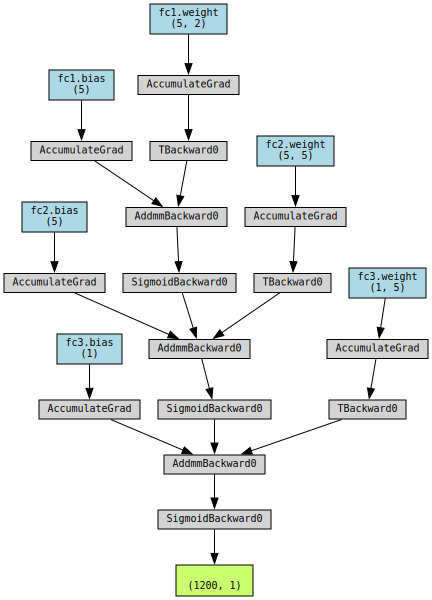

In [59]:
torchviz.make_dot(model(X), params=dict(model.named_parameters()))

In [70]:
loss      = nn.MSELoss()
new_optimizer = torch.optim.Adam(model.parameters(), lr=0.5)

In [71]:
print( "before:      loss: %.4f accuracy: %.4f" %  fit(model, X,Y) )  # режим оцінки моделі
 
epochs = 1000                                                             # число епох
for epoch in range(epochs):                                               # епоха: прохід
    L,A = fit(model, X, Y)                                            # по всьому датасету
     
    if epoch % 100 == 0 or epoch == epochs-1:                 
        print(f'epoch: {epoch:5d} loss: {L:.4f} accuracy: {A:.4f}') 

before:      loss: 0.0097 accuracy: 0.9883
epoch:     0 loss: 0.0097 accuracy: 0.9883
epoch:   100 loss: 0.0096 accuracy: 0.9875
epoch:   200 loss: 0.0068 accuracy: 0.9925
epoch:   300 loss: 0.0067 accuracy: 0.9925
epoch:   400 loss: 0.0066 accuracy: 0.9933
epoch:   500 loss: 0.0065 accuracy: 0.9933
epoch:   600 loss: 0.0065 accuracy: 0.9933
epoch:   700 loss: 0.0065 accuracy: 0.9933
epoch:   800 loss: 0.0065 accuracy: 0.9933
epoch:   900 loss: 0.0065 accuracy: 0.9933
epoch:   999 loss: 0.0065 accuracy: 0.9933
